In [1]:
# voir https://makina-corpus.com/blog/metier/2019/python-carto

import pandas as pd
from opensky_api import OpenSkyApi
import matplotlib.pyplot as plt
from shapely.geometry import Point
%matplotlib inline
import geopandas
import requests

# Aircraft database

https://opensky-network.org/datasets/metadata/


In [2]:
df_aircraft = pd.read_csv("aircraftDatabase.csv", low_memory=False)
df_aircraft.head()

,icao24,registration,manufacturericao,manufacturername,model,typecode,serialnumber,linenumber,icaoaircrafttype,operator,...,status,built,firstflightdate,seatconfiguration,engines,modes,adsb,acars,notes,categoryDescription
0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,False,False,NaN,NaN
1,aa3487,N757F,NaN,Raytheon Aircraft Company,A36,NaN,E-3121,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,False,False,NaN,NaN
2,ae267b,6533,VOUGHT,Aerospatiale,MH-65C Dolphin,AS65,6182,NaN,H2T,NaN,...,NaN,NaN,NaN,NaN,NaN,False,False,False,NaN,No ADS-B Emitter Category Information
3,a4fa61,N42MH,NaN,Piper,PA-31-350,NaN,31-7852015,NaN,NaN,NaN,...,NaN,1977-01-01,NaN,NaN,LYCOMING TI0-540 SER,False,False,False,NaN,NaN
4,c04101,C-FYQA,NaN,Champion Aircraft Corporation,7GCA (Champion),NaN,420,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,False,False,False,NaN,NaN


# Airport code to Airport name 


In [3]:
df = pd.read_csv("airports.dat", header= None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA,-6.081690,145.391998,5282,10,U,Pacific/Port_Moresby,airport,OurAirports
1,2,Madang Airport,Madang,Papua New Guinea,MAG,AYMD,-5.207080,145.789001,20,10,U,Pacific/Port_Moresby,airport,OurAirports
2,3,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH,-5.826790,144.296005,5388,10,U,Pacific/Port_Moresby,airport,OurAirports
3,4,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ,-6.569803,146.725977,239,10,U,Pacific/Port_Moresby,airport,OurAirports
4,5,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY,-9.443380,147.220001,146,10,U,Pacific/Port_Moresby,airport,OurAirports


In [4]:
df_airport = df.loc[:,1:5]
df_airport.columns=['Name','City','Country','IATA','ICAO']
df_airport.head()

,Name,City,Country,IATA,ICAO
0,Goroka Airport,Goroka,Papua New Guinea,GKA,AYGA
1,Madang Airport,Madang,Papua New Guinea,MAG,AYMD
2,Mount Hagen Kagamuga Airport,Mount Hagen,Papua New Guinea,HGU,AYMH
3,Nadzab Airport,Nadzab,Papua New Guinea,LAE,AYNZ
4,Port Moresby Jacksons International Airport,Port Moresby,Papua New Guinea,POM,AYPY


In [5]:
df_airport.loc[df_airport['City'] == 'Paris']

,Name,City,Country,IATA,ICAO
1344,Paris-Le Bourget Airport,Paris,France,LBG,LFPB
1346,Charles de Gaulle International Airport,Paris,France,CDG,LFPG
1350,Paris-Orly Airport,Paris,France,ORY,LFPO
6794,Cox Field,Paris,United States,PRX,KPRX


Maintenant nous avons le code de l'aéroport pour Charles de Gaulle LFPG et nous pourrons après utiliser ce tableau pour convertir le code aéroport en son nom.

# Departure Airport

In [113]:
import time
from datetime import datetime, timedelta
tnow = int(time.time())-3600*24
print(tnow)
print(datetime.fromtimestamp(tnow).strftime("%d/%m/%Y %H:%M"))
t0 = tnow-3600*8
print(t0)
print(datetime.fromtimestamp(t0).strftime("%d/%m/%Y %H:%M"))

1553379606
23/03/2019 23:20
1553350806
23/03/2019 15:20


In [114]:
url="https://opensky-network.org/api/flights/departure?airport=LFPG&begin="+str(t0)+"&end="+str(tnow)

In [115]:
data = requests.get(url).json()
df_data = pd.DataFrame.from_dict(data, orient='columns')
df_data.head()
print( list(df_data.columns.values))

['arrivalAirportCandidatesCount', 'callsign', 'departureAirportCandidatesCount', 'estArrivalAirport', 'estArrivalAirportHorizDistance', 'estArrivalAirportVertDistance', 'estDepartureAirport', 'estDepartureAirportHorizDistance', 'estDepartureAirportVertDistance', 'firstSeen', 'icao24', 'lastSeen']


In [116]:
df_departures = df_data.loc[:,["firstSeen",'callsign','icao24',"estDepartureAirport","estArrivalAirport"]]
df_departures['firstSeen'] = df_departures['firstSeen'].apply(lambda x: datetime.fromtimestamp(x).strftime("%H:%M - %d/%m/%Y"))
#df_departures['estArrivalAirportHorizDistance'] = df_departures['estArrivalAirportHorizDistance'].apply(lambda x: x/1000)
s = df_airport.set_index('ICAO')['Name']
df_departures["estDepartureAirport"] = df_departures["estDepartureAirport"].replace(s)
df_departures["estArrivalAirport"] = df_departures["estArrivalAirport"].replace(s)
a = df_aircraft.set_index('icao24')['model']
#df_departures["icao24"] = df_departures["icao24"].replace(a)


In [117]:
df_departures.head(10)

,firstSeen,callsign,icao24,estDepartureAirport,estArrivalAirport
0,22:28 - 23/03/2019,EIN529,4ca281,Charles de Gaulle International Airport,EIBA
1,22:25 - 23/03/2019,AFR87ZL,3991e8,Charles de Gaulle International Airport,Edinburgh Airport
2,22:21 - 23/03/2019,BCS6778,3c5423,Charles de Gaulle International Airport,London Heathrow Airport
3,22:17 - 23/03/2019,AFR42LJ,3944ea,Charles de Gaulle International Airport,LFNL
4,22:16 - 23/03/2019,AFR1400,394c19,Charles de Gaulle International Airport,Adolfo Suárez Madrid–Barajas Airport
5,21:53 - 23/03/2019,AFR57GD,392aea,Charles de Gaulle International Airport,Toulouse-Blagnac Airport
6,21:52 - 23/03/2019,FDX5391,abf0c7,Charles de Gaulle International Airport,London Stansted Airport
7,21:48 - 23/03/2019,AFR41MJ,3950c5,Charles de Gaulle International Airport,Salon-de-Provence (BA 701) Air Base
8,21:48 - 23/03/2019,AFR772P,394c14,Charles de Gaulle International Airport,Nantes Atlantique Airport
9,21:39 - 23/03/2019,AFR96UA,3946e9,Charles de Gaulle International Airport,Copenhagen Kastrup Airport


# Arrivals Airport

Procurons nous l'instant t maintenant et j-1 en tant absolu Unix Time Stamp

In [129]:
import time
from datetime import datetime, timedelta
tnow = int(time.time())-3600*24  # t now à j-1
print(tnow)
print(datetime.fromtimestamp(tnow).strftime("%d/%m/%Y %H:%M"))
t0 = tnow-3600*5
print(datetime.fromtimestamp(t0).strftime("%d/%m/%Y %H:%M"))

1553379800
23/03/2019 23:23
23/03/2019 18:23


In [130]:
url="https://opensky-network.org/api/flights/arrival?airport=LFPG&begin="+str(t0)+"&end="+str(tnow)

In [131]:
data = requests.get(url).json()
dataframe1 = pd.DataFrame.from_dict(data, orient='columns')
dataframe1.head()
print( list(dataframe1.columns.values))

['arrivalAirportCandidatesCount', 'callsign', 'departureAirportCandidatesCount', 'estArrivalAirport', 'estArrivalAirportHorizDistance', 'estArrivalAirportVertDistance', 'estDepartureAirport', 'estDepartureAirportHorizDistance', 'estDepartureAirportVertDistance', 'firstSeen', 'icao24', 'lastSeen']


In [132]:
df_arrivals = dataframe1.loc[:,['callsign',"estArrivalAirport","estDepartureAirport","firstSeen","lastSeen"]]
df_arrivals= df_arrivals.rename(columns ={'estArrivalAirport':'ArrivalAirport','estDepartureAirport':'DepartureAirport'})
s = df_airport.set_index('ICAO')['Name']
df_arrivals["DepartureAirport"] = df_arrivals["DepartureAirport"].replace(s)
df_arrivals["ArrivalAirport"] = df_arrivals["ArrivalAirport"].replace(s)
df_arrivals['FlighTimeSec'] = df_arrivals['lastSeen']- df_arrivals['firstSeen']
df_arrivals['FlighTime'] = df_arrivals['FlighTimeSec'].apply(lambda x: timedelta(seconds=x))
df_arrivals = df_arrivals.drop('FlighTimeSec', 1)

In [133]:
df_arrivals['firstSeen'] = df_arrivals['firstSeen'].apply(lambda x: datetime.fromtimestamp(x).strftime("%H:%M - %d/%m/%Y"))
df_arrivals['lastSeen'] = df_arrivals['lastSeen'].apply(lambda x: datetime.fromtimestamp(x).strftime("%H:%M - %d/%m/%Y"))

In [134]:
df_arrivals.head(10)

,callsign,ArrivalAirport,DepartureAirport,firstSeen,lastSeen,FlighTime
0,KAL504,Charles de Gaulle International Airport,London Heathrow Airport,22:34 - 23/03/2019,23:15 - 23/03/2019,00:41:07
1,VLG6GG,Charles de Gaulle International Airport,London Gatwick Airport,22:41 - 23/03/2019,23:14 - 23/03/2019,00:33:08
2,EZY3958,Charles de Gaulle International Airport,Málaga Airport,21:10 - 23/03/2019,23:13 - 23/03/2019,02:02:40
3,AZA332,Charles de Gaulle International Airport,Leonardo da Vinci–Fiumicino Airport,21:34 - 23/03/2019,23:08 - 23/03/2019,01:34:00
4,LBT518,Charles de Gaulle International Airport,None,21:04 - 23/03/2019,22:42 - 23/03/2019,01:38:51
5,IBS3742,Charles de Gaulle International Airport,Adolfo Suárez Madrid–Barajas Airport,21:00 - 23/03/2019,22:38 - 23/03/2019,01:37:37
6,AFR79MQ,Charles de Gaulle International Airport,None,20:01 - 23/03/2019,22:23 - 23/03/2019,02:22:05
7,AFL2460,Charles de Gaulle International Airport,Sheremetyevo International Airport,18:47 - 23/03/2019,22:21 - 23/03/2019,03:34:28
8,BAW326,Charles de Gaulle International Airport,London Heathrow Airport,21:33 - 23/03/2019,22:12 - 23/03/2019,00:38:17
9,AFR75SZ,Charles de Gaulle International Airport,Berlin-Tegel Airport,20:36 - 23/03/2019,22:02 - 23/03/2019,01:26:21


# Flights in time interval on France

In [137]:
#bboxFrance= [min_latitude, max_latitude, min_longitude, max_latitude]
bboxFrance= [41, 52, -5.5, 10]

In [149]:
import time
t = int(time.time())
print(t)
print(datetime.fromtimestamp(t).strftime("%d/%m/%Y %H:%M"))

1553466790
24/03/2019 23:33


In [150]:
#  fly data
data =[]
api = OpenSkyApi()
states = api.get_states(time_secs= t, bbox=bboxFrance)
for s in states.states:
    #print("(%r, %r, %r, %r)" % (s.longitude, s.latitude, s.velocity, s.callsign))
    if s.latitude != None and s.longitude != None:
       data.append(( s.callsign, float(s.longitude), float(s.latitude) ))
    else :
        pass
print(data[0:5]) 
print(len(data))

[('SWR1623 ', 8.5581, 47.4534), ('SWR117G ', 9.2016, 48.6893), ('DLH6ET  ', -0.134, 51.7828), ('WZZ143  ', 8.4135, 50.9399), ('AFR6231 ', 6.6615, 44.242)]
278


In [151]:
df = pd.DataFrame(data, columns=['callsign', 'longitude', 'latitude'])

In [152]:
df.head()

,callsign,longitude,latitude
0,SWR1623,8.5581,47.4534
1,SWR117G,9.2016,48.6893
2,DLH6ET,-0.1340,51.7828
3,WZZ143,8.4135,50.9399
4,AFR6231,6.6615,44.2420


In [153]:
df['Coordinates'] = list(zip(df.longitude, df.latitude))

In [154]:
df['Coordinates'] = df['Coordinates'].apply(Point)

In [155]:
gdf = geopandas.GeoDataFrame(df, geometry='Coordinates')

In [156]:
print(gdf.head())

   callsign  longitude  latitude                        Coordinates
0  SWR1623      8.5581   47.4534             POINT (8.5581 47.4534)
1  SWR117G      9.2016   48.6893  POINT (9.201599999999999 48.6893)
2  DLH6ET      -0.1340   51.7828             POINT (-0.134 51.7828)
3  WZZ143       8.4135   50.9399  POINT (8.413500000000001 50.9399)
4  AFR6231      6.6615   44.2420              POINT (6.6615 44.242)


In [157]:
# Utilisation d'une autre carte plus adéquate
fp = "Europe_borders.shp"
europe = geopandas.read_file(fp)
europe.head()

,TZID,geometry
0,Europe/Berlin,"POLYGON ((8.457777976989746 54.56236267089844,..."
1,Europe/Berlin,"POLYGON ((8.71992015838623 47.69664382934571, ..."
2,Europe/Berlin,"POLYGON ((6.733166694641113 53.5740852355957, ..."
3,Europe/Berlin,"POLYGON ((6.858222007751465 53.59411239624024,..."
4,Europe/Berlin,"POLYGON ((6.89894437789917 53.6256103515625, 6..."


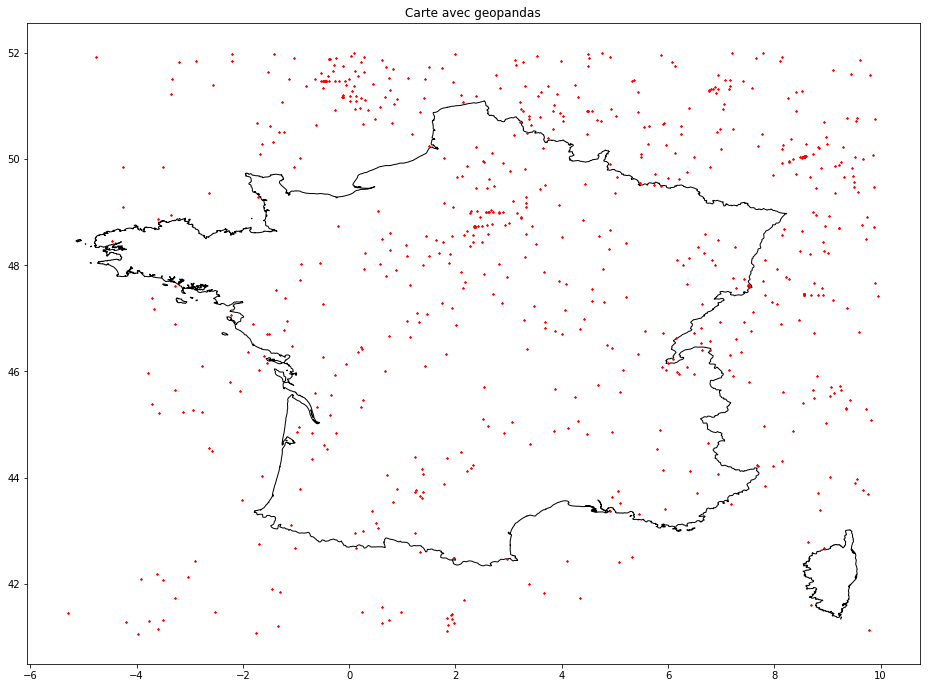

In [179]:
fig, ax = plt.subplots(figsize=(16, 16))
ax.set_aspect('equal')
europe[europe.TZID == 'Europe/Paris'].plot(ax=ax, color='white', edgecolor='black')
gdf.plot(ax=ax, marker='*', color='red', markersize=3)
ax.set_title('Carte avec geopandas');